Name  : SILVA G.B.N.M. <br>
Index : 190592X

Q1

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf
import cv2 as cv

Q1

In [8]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t),(r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))

m, b = -1, 2
x = np.linspace(-12, 12 , half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X = np.vstack((X_circ,X_line))

In [40]:
def circle_ransac(data,error,s):
    threshold = np.std(data)/18
    required_iterations = np.log(1-(1-error))/np.log(1-(1-0.5)**s)
    max_inliers = 0
    model = None
    print(required_iterations,np.int64(np.ceil(required_iterations)))
    for iterations in range (np.int64(np.ceil(required_iterations))):
        np.random.shuffle(data)
        samples = data[:s]
        x_c,y_c,r,_ = cf.least_squares_circle((samples))
        err = np.abs(r - np.sqrt(np.sum(((x_c,y_c)-data[s:])**2,axis=1)))
        inliers = err <= threshold
        tot_inliers = np.count_nonzero(inliers)
        if tot_inliers >max_inliers :
            max_inliers = tot_inliers
            inlier_points = []
            for ind,inlr in enumerate(inliers):
                if inlr == True :
                    inlier_points.append(data[s:][ind])
            inlier_points = np.array(inlier_points)
            model = (samples,inlier_points)

    xc , yc , radius , _ = cf.least_squares_circle(np.concatenate((model[0],model[1]),axis = 0)) 
    return ((xc,yc),radius,model[0],model[1])  


1.5382162637106231 2


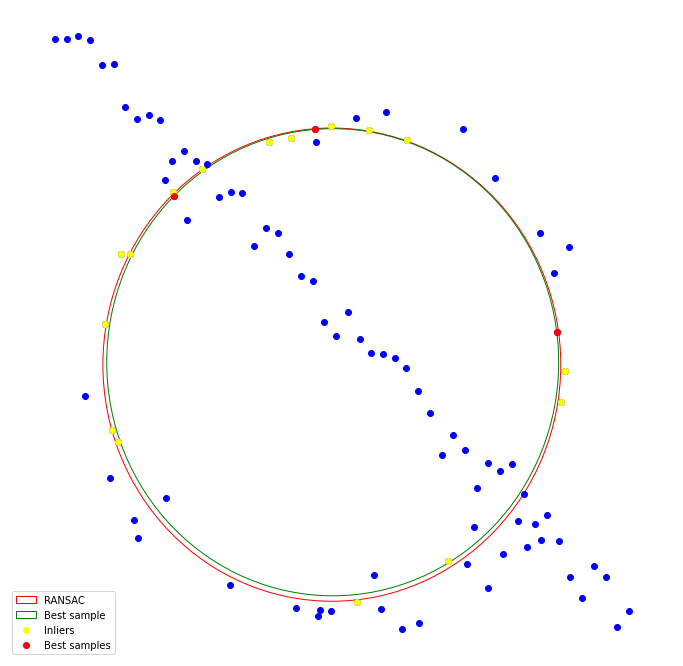

In [43]:
best_model = circle_ransac(X_circ,0.05,3)
xc,yc,r,_ = cf.least_squares_circle(best_model[2])

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_model[0], best_model[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(X_circ[:, 0], X_circ[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_model[3][:, 0], best_model[3][:, 1], c='yellow', label='Inliers')
ax.scatter(best_model[2][:, 0], best_model[2][:, 1], c='red', label='Best samples')
plt.legend(loc=3)
plt.xlim(-14, 14)
plt.axis('off')
plt.savefig(r"images\1.png")
plt.show()

Q2

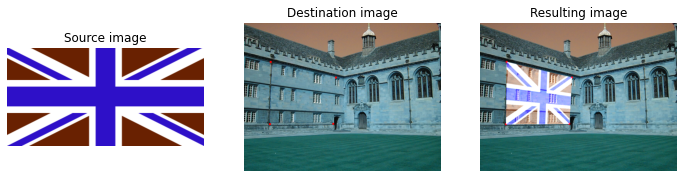

In [3]:
src_img = cv.imread(r'images/Flag_of_the_United_Kingdom.png')
dest_img = cv.imread(r'images/2.jpg')

points = []
h,w,c = src_img.shape
src_pts = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])

def marker(img, x, y):
    for i in range(y-5, y+5):
        for j in range(x-5, x+5):
            img[i][j] = [255,0,0]
    return

def point_selector(event,x,y,flags,param):
    if event == cv.EVENT_LBUTTONDOWN and len(points)<4:
        marker(dest_img,x,y)
        points.append([x,y])
        cv.imshow("Source image",dest_img)
        if len(points)==4:
            cv.destroyAllWindows()
            dest_pts = np.array(points)
            homography , _ = cv.findHomography(np.float32(src_pts),np.float32(dest_pts), cv.RANSAC, 5.0)
            output_img = cv.warpPerspective(src_img,homography,(dest_img.shape[1],dest_img.shape[0]))
            output_img = cv.addWeighted(dest_img,1,output_img,1,0)
            fig,ax = plt.subplots(1,3,figsize = (12,10))
            ax[0].imshow(src_img)
            ax[0].set_title("Source image")
            ax[0].axis('off')
            ax[1].imshow(dest_img)
            ax[1].set_title("Destination image")
            ax[1].axis('off')
            ax[2].imshow(output_img)
            ax[2].set_title("Resulting image")
            ax[2].axis('off')
            plt.savefig(r"images/q2.png")
            plt.show()
            return

cv.namedWindow(winname = "Source image")
cv.setMouseCallback("Source image",point_selector)
cv.imshow("Source image",dest_img)
cv.waitKey(0)
cv.destroyAllWindows()

Q3 a)

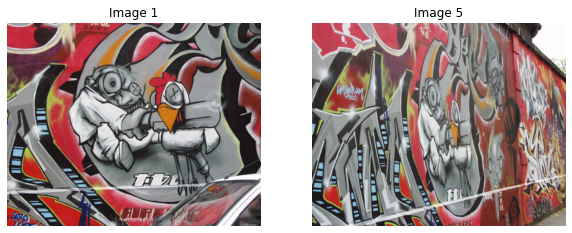

In [38]:
im1 = cv.imread(r'images/img1.ppm')
im2 = cv.imread(r'images/img5.ppm')

im1 = cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2,cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(im1)
ax[0].axis('off')
ax[0].set_title('Image 1')
ax[1].imshow(im2)
ax[1].axis('off')
ax[1].set_title('Image 5')
plt.show()

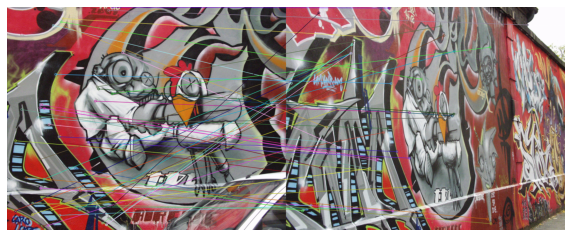

In [39]:
def sift_matcher(img1,img2):
    sift = cv.SIFT_create()
    kp1_, desc1 = sift.detectAndCompute(im1,None)
    kp2_, desc2 = sift.detectAndCompute(im2,None)
    bf_match = cv.BFMatcher(cv.NORM_L1)
    matches_ = bf_match.knnMatch(desc1,desc2,k=2)
    best_,pts1_,pts2_ = [] , [] , []
    for pt1,pt2 in matches_:
        if pt1.distance < 0.75 * pt2.distance:
            best_.append([pt1])
            pts1_.append(kp1_[pt1.queryIdx].pt)
            pts2_.append(kp2_[pt2.trainIdx].pt)
    best_ , pts1_ , pts2_ = np.array(best_) , np.array(pts1_) , np.array(pts2_)
    output = [best_,kp1_,kp2_,pts1_,pts2_]
    return output

best , kp1 , kp2 , pts1 , pts2 = sift_matcher(im1,im2)
mtch_img = cv.drawMatchesKnn(im1,kp1,im2,kp2,best[:50],None,flags = 2)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(mtch_img)
ax.axis('off')
plt.savefig(r"images\q3a.jpg")
plt.show()

Q3 b)

Homography without using RANSAC

In [40]:
def Homography(pts_1,pts_2):
    mean_1,mean_2 = np.mean(pts_1,axis=0) , np.mean(pts_2,axis=0)
    s_1 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts_1-mean_1)**2,axis = 1))) 
    s_2 = len(pts2)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts_2-mean_2)**2,axis = 1))) 

    tx_1 , ty_1 , tx_2, ty_2 = -s_1*mean_1[0], -s_1*mean_1[1] , -s_2*mean_2[0] , -s_2*mean_2[1]
    T_1 = np.array(((s_1,0,tx_1),(0,s_1,ty_1),(0,0,1)))
    T_2 = np.array(((s_2,0,tx_2),(0,s_2,ty_2),(0,0,1)))

    x_i = []

    for i in range (len(pts_1)):
        x_11 = T_1 @ np.concatenate((pts_1[i],[1])).reshape(3,1)
        x_21 = T_2 @ np.concatenate((pts_2[i],[1])).reshape(3,1)

        x_i.append((-x_11[0][0],-x_11[1][0],-1,0,0,0,x_21[0][0]*x_11[0][0],x_21[0][0]*x_11[0][0],x_21[0][0]))        
        x_i.append((0,0,0,-x_11[0][0],-x_11[1][0],-1,x_21[1][0]*x_11[1][0],x_21[1][0]*x_11[1][0],x_21[1][0]))

    x_i = np.array(x_i)
    U , S , V = np.linalg.svd(x_i, full_matrices=True)
    h = np.reshape(V[-1],(3,3))
    H = linalg.inv(T_2) @ h @ T_1
    H = (1 / H.item(8)) * H
    return H


In [41]:
def distance_calc(pnt1,pnt2,homography):
    pt1 = np.array([pnt1[0],pnt1[1],1])
    pt2 = np.array([pnt2[0],pnt2[1],1])

    pt2_est = np.dot(homography,pt1.T)
    pt2_est = pt2_est * ( 1 / pt2_est[2])
    return np.linalg.norm(pt2.T - pt2_est)

Homography With RANSAC

In [42]:
def Homography_Ransac(pts1,pts2,s,error):
    tot_inliers = 0
    selected = None
    pts = np.hstack((pts1,pts2))
    req_iterations = np.log(1-(1-error))/np.log(1-(1-0.5)**s)

    for i in range(int(np.ceil(req_iterations))):
        np.random.shuffle(pts)
        points1,points1_rest = pts[:s,:2],pts[s:,:2]
        points2,points2_rest = pts[:s,2:],pts[s:,2:]

        H = Homography(points1,points2)
        inliers = [(points1_rest[j],points2_rest[j]) for j in range(len(points1_rest)) if distance_calc(points1_rest[j],points2_rest[j],H)<100]
        # for j in range(len(points1_rest)):
        #     p1 = np.array([points1_rest[j][0],points1_rest[j][1],1])
        #     p2 = np.array([points2_rest[j][0],points2_rest[j][1],1])

        #     est_pt2 = np.dot(H,np.transpose(p1))
        #     est_pt2 = (1 / est_pt2[2]) * est_pt2

        #     if np.linalg.norm(np.transpose(p2)-est_pt2) < 50 :
        #         inliers.append((points1_rest[j],points2_rest[j]))
        
        # inliers = np.array(inliers)

        if len(inliers) > tot_inliers :
            tot_inliers = len(inliers)
            selected = np.array(inliers)
    H2 = Homography(selected[:,0],selected[:,1])
    return H2

In [44]:
H_with_RANSAC = Homography_Ransac(pts1,pts2,4,0.05)
print("Homography calculated using manual function : \n",H_with_RANSAC)

given_homography_file = open(r'images/H1to5p','r')

given_homography = []

for _ in range(3):
    given_homography.append(tuple(map(float,given_homography_file.readline().strip().split())))
given_homography = np.array(given_homography)

print("Given Homography :\n",given_homography)

Homography calculated using manual function : 
 [[ 1.51424222e+00 -1.51424222e+00  2.17713582e+02]
 [ 9.98370452e-01 -9.98370452e-01  1.43542958e+02]
 [ 6.95520328e-03 -6.95520328e-03  1.00000000e+00]]
Given Homography :
 [[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


Q3 c)

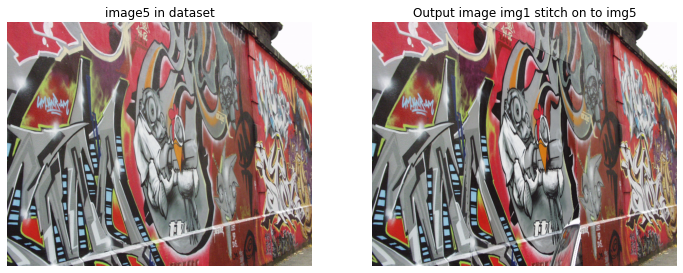

In [11]:
#Warping the image1 using the given homography
warped_1_gvn = cv.warpPerspective(im1,given_homography,(im2.shape[1],im2.shape[0]))
_,thresh = cv.threshold(warped_1_gvn,10,1,cv.THRESH_BINARY_INV)
thresh_im2 = np.multiply(thresh,im2)

output_img = cv.addWeighted(thresh_im2,1,warped_1_gvn,1,0)

fig,ax = plt.subplots(1,2,figsize = (12,10))
ax[0].imshow(im2)
ax[0].set_title("image5 in dataset")
ax[0].axis('off')
ax[1].imshow(output_img)
ax[1].set_title("Output image img1 stitch on to img5")
ax[1].axis('off')
plt.savefig(r"images/q3_c.png")
plt.show()